# Building ML Models for SRF Cavity Classification
Chris Tennant <br>
_December 17, 2019_
***

_re-training models with newest version of `tsfresh` v.0.13.0_

Import `pandas`, `matplotlib`, `numpy` and `os` libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

dir = Path('C:/Users/tennant/Desktop/rfw_tsf_extractor-Spring-2018/extracted')

Read in .csv files with features computed by `tsfresh`.

In [2]:
y_master = pd.read_csv(dir/'y_cavity_master.csv')

In [3]:
X_master = pd.read_csv(dir/'X_cavity_master.csv')

In [4]:
y_master = y_master.drop(columns=['zone', 'time'])

In [5]:
X_master = X_master.drop(columns=['zone', 'time'])

In [6]:
print("Number of training examples: {}".format(X_master.shape[0]))
print("Number of features: {}".format(X_master.shape[1]))
print("Number of categories: {}".format(y_master['label'].nunique()))

Number of training examples: 348
Number of features: 24128
Number of categories: 9


To further reduce computational load, only use `fft_coefficient` features.

In [7]:
X_master = X_master.filter(regex='fft_coefficient', axis=1)

In [8]:
print("Number of features: {}".format(X_master.shape[1]))
print("400 'fft_coefficient' features per signal")

Number of features: 12800
400 'fft_coefficient' features per signal


Histogram showing how the distribution of the types of faults in the data set.

In [9]:
y_master['label'].value_counts()

1    72
0    59
6    48
7    41
3    40
4    33
8    31
2    19
5     5
Name: label, dtype: int64

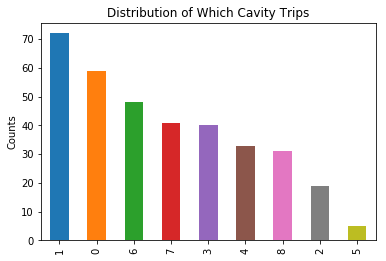

In [10]:
#y_master.T.head(55)
y_master['label'].value_counts().plot(kind='bar');
plt.title("Distribution of Which Cavity Trips");
plt.ylabel("Counts");
#plt.savefig("faults_bar.png", bbox_inches = "tight", dpi=200)

Split the data into training and test sets using `train_test_split` from `sklearn`. Keep 30% of the data for testing. Note that we use `stratify` to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set (important when dealing with small data sets like this one).

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_master, y_master, test_size = 0.3, random_state=123, stratify=y_master)

In [12]:
print("The number of training examples is: {}".format(X_train.shape[0]))
print("The number of test examples is: {}".format(X_test.shape[0]))

The number of training examples is: 243
The number of test examples is: 105


In [13]:
y_train['label'].value_counts()

1    50
0    41
6    34
7    29
3    28
4    23
8    22
2    13
5     3
Name: label, dtype: int64

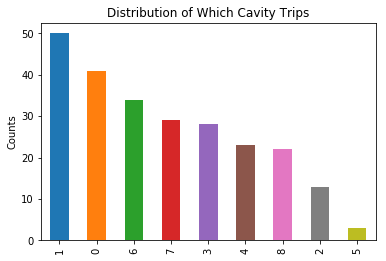

In [14]:
y_train['label'].value_counts().plot(kind='bar');
plt.title("Distribution of Which Cavity Trips");
plt.ylabel("Counts");
#plt.savefig("faults_bar.png", bbox_inches = "tight", dpi=200)

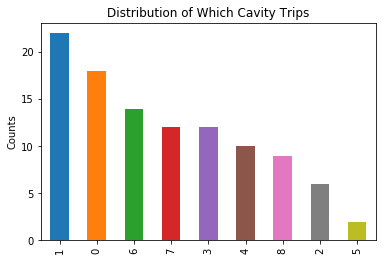

In [15]:
y_test['label'].value_counts().plot(kind='bar');
plt.title("Distribution of Which Cavity Trips");
plt.ylabel("Counts");
#plt.savefig("faults_bar.png", bbox_inches = "tight", dpi=200)

Need to standardize features by removing the mean and scaling to unit variance. Note to avoid _data leak_ we standardize the training data and then use the same step (including the same values for mean and standard deviation) on the test set.
<br><br>
_(Note, it may be wise to standardize the initial time-series signals before computing features. However, it requires having all the data together in a single `DataFrame`. Due to computational issues with `tsfresh`, this is not possible and need to compute small batches of data at a time)._

In [16]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)

Save (mean, variance) values as `numpy` arrays for use with saved model when deployed.

In [17]:
X_train_mean = sc.fit(X_train).mean_
X_train_var = sc.fit(X_train).scale_

np.save('RF_CAVITY_fft_only_data_mean', X_train_mean, allow_pickle=False)
np.save('RF_CAVITY_fft_only_data_var', X_train_var, allow_pickle=False)

No need to convert labels (`y_train` and `y_test`) since they are `int64` and not categorical.

In [18]:
import tsfresh
from tsfresh import select_features
from tsfresh import feature_selection
from tsfresh.utilities.dataframe_functions import impute

In [19]:
print(tsfresh.__version__)

0.13.0


Use `impute` from `tsfresh` to replace all `NaNs` and `infs` from the `DataFrame` with average/extreme values from the same columns.

In [20]:
X_train_scaled = impute(X_train_scaled)
X_test_scaled = impute(X_test_scaled)

Import libraries containing performance metrics and models.

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from matplotlib import pyplot

Evaluate models using code from *"Machine Learning Mastery with Python"*.<br>
Model performance is evaluated using _k_-folds cross-validation, so the test set remains untouched.

In [25]:
# prepare models
models = []
#non-linear models
models.append(('KNN', KNeighborsClassifier(n_neighbors=4)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('SVC', SVC(gamma='auto')))
models.append(('BAYES', GaussianNB()))
# ensemble models
models.append(('BAG', BaggingClassifier(n_estimators=100)))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('XT', ExtraTreesClassifier(n_estimators=100)))
models.append(('GBM', GradientBoostingClassifier(n_estimators=100)))
#models.append(('AB', AdaBoostClassifier(n_estimators=100)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=3, random_state=7)
    cv_results = cross_val_score(model, X_train_scaled, np.ravel(y_train), cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.753086 (0.043939)
DT: 0.777778 (0.043939)
SVC: 0.839506 (0.026670)
BAYES: 0.818930 (0.067117)
BAG: 0.880658 (0.057318)
RF: 0.905350 (0.025368)
XT: 0.905350 (0.030796)
GBM: 0.790123 (0.043939)


In [26]:
np.save('CAVITY_CV_results', results, allow_pickle=False)
names

['KNN', 'DT', 'SVC', 'BAYES', 'BAG', 'RF', 'XT', 'GBM']

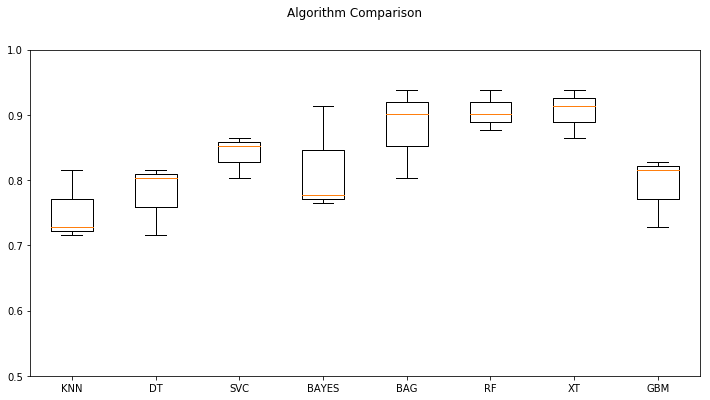

In [27]:
# boxplot algorithm comparison
fig = pyplot.figure(figsize=(12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.ylim((0.5,1))
pyplot.show()

Choose the `RandomForest` for its performance and also robustness against overfitting. Use `GridSearch` to perform hyperparameter tuning.

In [28]:
from sklearn.model_selection import GridSearchCV
parameter_candidates = {'n_estimators': np.arange(25,250,25), 'min_samples_split': np.arange(2,18,1), 'max_depth': np.arange(2,18,1)}

In [29]:
# create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, verbose=1, cv=3)

# train the classifier 
%time clf.fit(X_train_scaled, np.ravel(y_train)) 

Fitting 3 folds for each of 2304 candidates, totalling 6912 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6912 out of 6912 | elapsed: 62.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 1h 2min 18s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([ 25,  50,  75, 100, 125, 150, 175, 200, 225]), 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [30]:
# view the accuracy score
print('Best accuracy score for training data:', clf.best_score_) 

# view the best parameters for the model found using grid search
print('Best min_samples_split:', clf.best_estimator_.min_samples_split)
print('Best max_depth:', clf.best_estimator_.max_depth)
print('Best n_estimators:', clf.best_estimator_.n_estimators)

Best accuracy score for training data: 0.9176954732510288
Best min_samples_split: 2
Best max_depth: 8
Best n_estimators: 100


Use the best parameters to define the model.

In [31]:
RF_model = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=2, max_features=None, random_state=11)
RF_model.fit(X_train_scaled, np.ravel(y_train))
print(RF_model.score(X_test_scaled, np.ravel(y_test)))

0.9428571428571428


Use _k_-folds cross-validation with `cv=3` to check for overfitting with the `RandomForest`.

In [32]:
scores = cross_val_score(RF_model, X_train_scaled, np.ravel(y_train), cv=3)
print("The mean accuracy score is: ({:.2f} +/- {:.2f})%".format(100*scores.mean(), 100*scores.std()))

The mean accuracy score is: (93.09 +/- 2.28)%


Save final `RandomForestClassifier` model using `joblib` (more [here](https://chrisalbon.com/machine_learning/basics/saving_machine_learning_models/))

In [22]:
# save model using joblib
from sklearn.externals import joblib
from sklearn.externals import joblib

#filename_joblib = 'RF_CAVITY_fft_only_data_12172019_TMP.sav'
#joblib.dump(RF_model, filename_joblib)

# save model using pickle
from pickle import dump
from pickle import load

filename_pickle = 'RF_CAVITY_fft_only_data_TMP.pkl'
#dump(RF_model, open(filename_pickle, 'wb'))

In [23]:
joblib.__version__

'0.13.0'

Generate a `classification_report` using the `RandomForestClassifier`.

In [35]:
y_pred = RF_model.fit(X_train_scaled, np.ravel(y_train)).predict(X_test_scaled)
print(classification_report(np.ravel(y_test), y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       1.00      1.00      1.00        22
           2       0.86      1.00      0.92         6
           3       0.92      1.00      0.96        12
           4       1.00      0.80      0.89        10
           5       0.00      0.00      0.00         2
           6       0.93      1.00      0.97        14
           7       0.92      1.00      0.96        12
           8       1.00      1.00      1.00         9

   micro avg       0.94      0.94      0.94       105
   macro avg       0.84      0.85      0.84       105
weighted avg       0.93      0.94      0.93       105



The confusion matrix - another performance metric (see A. Geron pp. 98-99).

In [32]:
conf_mx = confusion_matrix(np.ravel(y_test), y_pred)

Use [script](https://github.com/DTrimarchi10/confusion_matrix) to create nicer looking confusion matrix.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

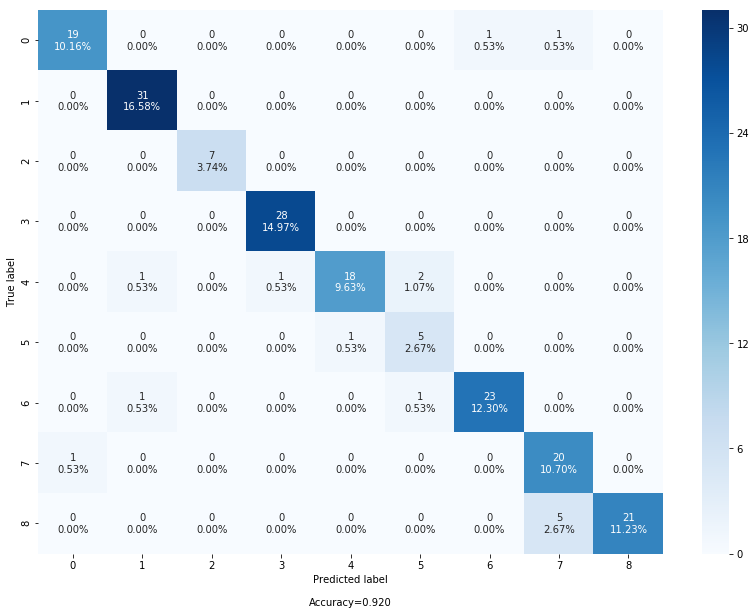

In [34]:
make_confusion_matrix(conf_mx, figsize=(14,10), cbar=True)

In [35]:
#plt.matshow(conf_mx, cmap=plt.cm.gray)
#plt.show()

Plot the confusion matrix while focusing on the errors (off-diagonal elements).

In [36]:
#row_sums = conf_mx.sum(axis=1, keepdims=True)
#norm_conf_mx = conf_mx / row_sums

# fill diagonal with zeros to only keep errors
#np.fill_diagonal(norm_conf_mx, 0)
#plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
#plt.show()

Check that the model can be loaded.

In [24]:
#RF_from_pickle = load(open('./models/RF_CAVITY_fft_only_data.pkl', 'rb'))
RF_from_joblib = joblib.load('RF_CAVITY_fft_only_data_12172019.sav')

Use the loaded model to make predictions.

In [25]:
#print(RF_from_pickle.score(X_test_scaled, np.ravel(y_test)))
print(RF_from_joblib.score(X_test_scaled, np.ravel(y_test)))

0.9428571428571428
